In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Set the notebook parameters, the path to the key file and change working-directory to the root directory of the dataprocessing framework.

In [2]:
import os
base_dir = '/local/scratch/toolkit/'
os.environ['EXOT_ACCESS_DIR'] = str(base_dir + "benchmark_platforms_access/")
os.chdir(base_dir + 'datapro')
print("Working directory: " + str(os.getcwd()))
print("Key directory set to: " + str(os.environ['EXOT_ACCESS_DIR']))

Working directory: /local/scratch/toolkit/datapro
Key directory set to: /local/scratch/toolkit/benchmark_platforms_access/


Import all necessary packages.

In [3]:
np.set_printoptions(linewidth=120)
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams["legend.loc"] = "lower right"

import toml    as TOML              # TOML library to handle config files
import pandas  as pd                # Pandas for data manipulation
import seaborn as sb                # Statistical data visualisation
import pathlib as PATH              # Used to convert strings to path objects for (de-)serialisation
import types   as tp                # Library used for online method development

# scikit-learn packets
import sklearn.base                 #
import sklearn.svm                  # LinearSVC, SVC
import sklearn.pipeline             # make_pipeline
import sklearn.preprocessing        # StandardScaler
import sklearn.decomposition        # PCA
import sklearn.naive_bayes          # GaussianNB
import sklearn.metrics              # CM

# Toolkit packets
import exot                       # Dataprocessing
import exot.experiment            # Experiment for execution
import exot.util                  # General utilities
import exot.layer                 # Data manipulation layers
from exot.util       import *
from exot.layer      import *
from exot.channel    import *
from exot.experiment import *

# Plotting
from exot.plotting.experiment_plotter import *
from exot.plotting.run_plotter        import *

Tensorflow not available - excluding packets using it!


Parameters

In [4]:
NB_EXPERIMENT = "thermal-cc_performance_masti"

environments_to_execute = [
    "ARMv7",
    "ARMv8",
    "Haswell",
    "Sandy"
]

phases = {
    "ARMv7": {
        "normal": ["train", "eval"],
    },
    "ARMv8": {
        "normal": ["train", "eval"],
    },
    "Haswell": {
        "normal": ["train", "eval"],
    },
    "Sandy": {
        "normal": ["train", "eval"],
    },
}

In [5]:
raise Exception("Are you sure?")

Exception: Are you sure?

# Generate Experiment
1. Load the configuration and define phases and environments

In [ ]:
config = TOML.load(f"configurations/{NB_EXPERIMENT}.toml")
print(TOML.dumps(config))

2. Instantiate, generate and write the experiment

In [ ]:
channel = ChannelFactory()(config["EXPERIMENT"]["channel"])
experiment = ExperimentFactory()(config["EXPERIMENT"]["type"], config=config, channel=channel)

experiment.generate()
experiment.print_duration()

# If exists...
if PATH.Path(f"data/{NB_EXPERIMENT}/").exists():
    # First move...
    experiment.config.experiment_exists_action = "move"
    experiment.write()

# Then set to update mode.
experiment.config.experiment_exists_action = "update"
experiment.write()

## Execute

Running `execute` will execute in all environments present in the configuration.

Show phases' durations.

In [ ]:
experiment.print_duration()

_Optionally_ peek at execution status. The execution status can be modified manually or via `_modify_execution_status`. If a modification has been made, push it to run instances with `_push_execution_status`. To rerun or resume execution, set the _resume_ argument to `True`.

In [ ]:
experiment.infer_execution_status(update_self=True, update_runs=True)
execution_status = experiment._execution_status

for _platform in phases:
    for phase, runs in execution_status.items():
        for run, statuses in runs.items():
            for platform, status in statuses:
                if _platform == platform and _platform in phase:
                    print(
                        "{}Phase: {:>20s} Run: {:3d} Platform: {:>8s} Status: {}".format(
                            "✓ " if any(status) else "✗ ", phase, run, platform, status
                        )
                    )

Finally, execute sequentially in all environments.

In [ ]:
raise Exception("Are you sure?")

In [ ]:
experiment.execute_in_environment('Haswell', ['trainTest', 'evalTest'], resume=False)

In [ ]:
for env in environments_to_execute:
    for phase in phases[env].items():
         experiment.execute_in_environment(env, phase, resume=False)
experiment.write()

# Demo
With the following cell you can visualise a single run from either platform and also have a look on the data histogram, to check whether the quantisation thresholds are defined correctly.

2020-04-16 09:55:16 :: unpicked an experiment instance <PerformanceExperiment at 0x7f976c0765f8 with ThermalCC channel, configured>
2020-04-16 09:55:16 :: configs from pickle and directory differ at [{'path': ('EXPERIMENT', 'LAYERS', 'lne', 'params'), 'left': {}, 'right': {'N': 2}}, {'path': ('EXPERIMENT', 'LAYERS', 'lne', 'params', 'N'), 'left': nan, 'right': 2}, {'path': ('EXPERIMENT', 'LAYERS', 'lne', 'name'), 'left': 'PassthroughLineCoding', 'right': 'MedianLineCoding'}]
2020-04-16 09:55:17 :: git commit of unpickled experiment repo '72570632' does not match the commit in which the unpickling was performed '02a9bbb8'
2020-04-16 09:55:17 :: bootstrapped layer 'src' with SourcePassthrough
2020-04-16 09:55:17 :: bootstrapped layer 'lne' with MedianLineCoding
2020-04-16 09:55:17 :: bootstrapped layer 'rdp' with CoreActivation
2020-04-16 09:55:17 :: bootstrapped layer 'io' with TimeValue
2020-04-16 09:55:36 :: bootstrapped layer 'src' with SourcePassthrough
2020-04-16 09:55:36 :: bootst

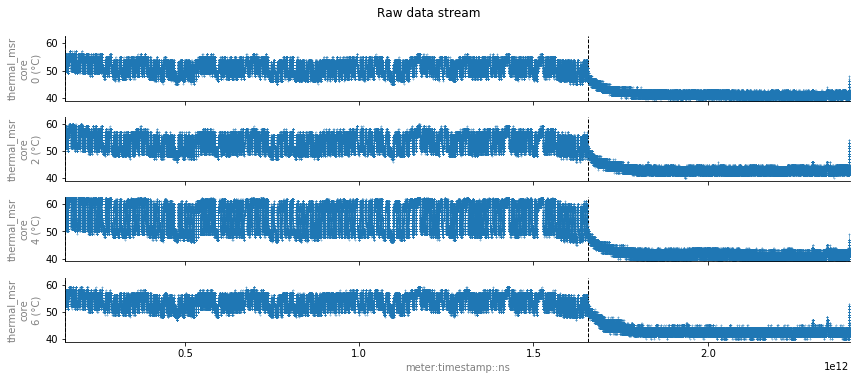

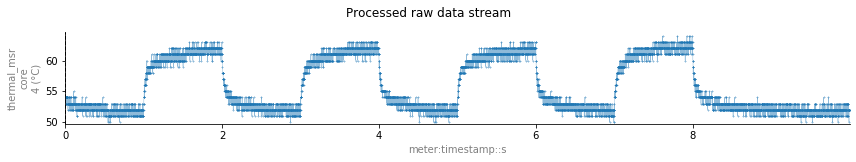

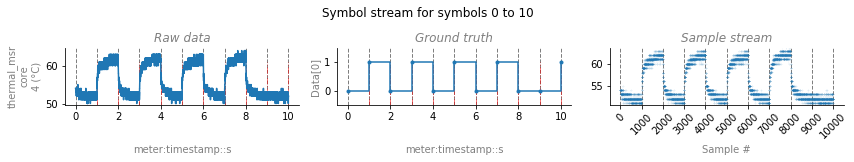

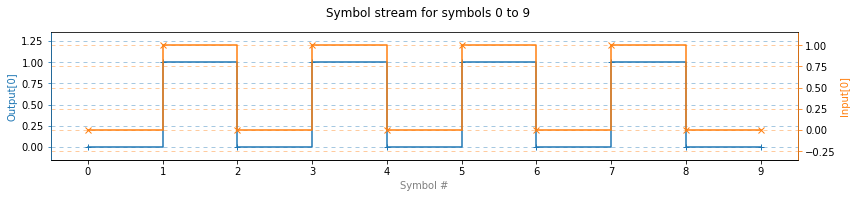

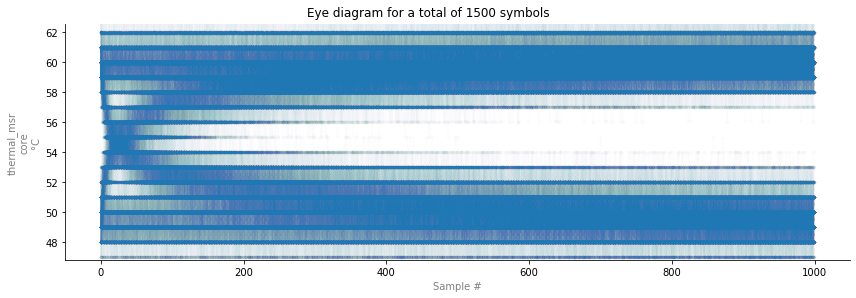

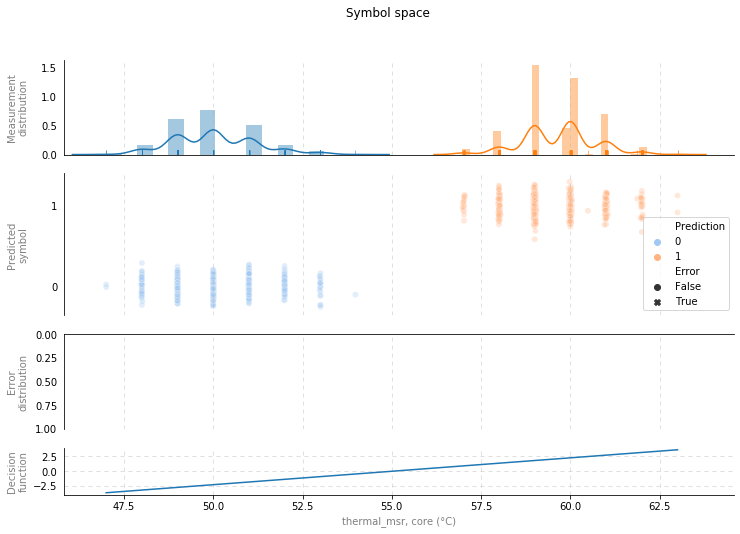

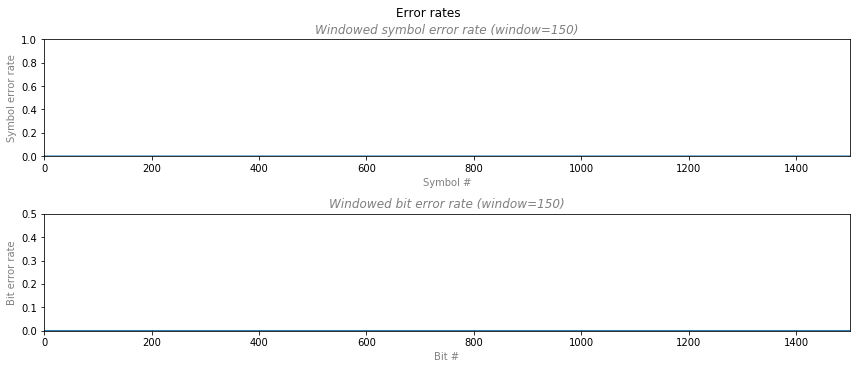

In [6]:
path_to_serialised_experiment = PATH.Path(f"data/{NB_EXPERIMENT}/_experiment.pickle")
experiment = PerformanceExperiment.read(path_to_serialised_experiment, diff_and_replace=True)
experiment.bootstrap()

DEMO_PHASE = "train"
DEMO_ID = 0
#DEMO_ENV = "ARMv7"
#DEMO_ENV = "ARMv8"
DEMO_ENV = "Haswell"
#DEMO_ENV = "Sandy"

#for DEMO_ENV in environments_to_execute:
ingest_args = dict(
    lne={
        "decision_device": sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC()
        )
    },
)
if DEMO_ENV == "ARMv7":
    ingest_args['io'] = {
            "env": "ARMv7",
            "rep": 0,
            "matcher": [(exot.util.wrangle.Matcher("thermal", "sysfs", ["zone"], [3]), None)]
            #"matcher": [(exot.util.wrangle.Matcher("thermal", "sysfs", ["zone"], list(range(5))), None)], "combine":"max",
        }
elif DEMO_ENV == "ARMv8":
    ingest_args['io'] = {
            "env": "ARMv8",
            "rep": 0,
            #"matcher": [(exot.util.wrangle.Matcher("thermal", "sysfs", ["zone"], [0]), None)]
            "matcher": [(exot.util.wrangle.Matcher("thermal", "sysfs", ["zone"], [1]), None)]
            #BAD "matcher": [(exot.util.wrangle.Matcher("thermal", "sysfs", ["zone"], [2]), None)]
            #"matcher": [(exot.util.wrangle.Matcher("thermal", "sysfs", ["zone"], [3]), None)]
            #BAD "matcher": [(exot.util.wrangle.Matcher("thermal", "sysfs", ["zone"], [4]), None)]
            #BAD "matcher": [(exot.util.wrangle.Matcher("thermal", "sysfs", ["zone"], [5]), None)]
            #"matcher": [(exot.util.wrangle.Matcher("thermal", "sysfs", ["zone"], list(range(6))), None)], "combine":"max",
        }
elif DEMO_ENV == "Haswell":
    ingest_args['io'] = {
            "env": "Haswell",
            "rep": 0,
            "matcher": [(exot.util.wrangle.Matcher("thermal", "msr", ["core"], [4]), None)]
            #"matcher": [(exot.util.wrangle.Matcher("thermal", "msr", ["core"], [0, 2, 4, 6]), None)], "combine":"max",
        }
elif DEMO_ENV == "Sandy":
    ingest_args['io'] = {
            "env": "Sandy",
            "rep": 0,
            "matcher": [(exot.util.wrangle.Matcher("thermal", "msr", ["core"], [2]), None)]
            #"matcher": [(exot.util.wrangle.Matcher("thermal", "msr", ["core"], [9]), None)]
            #"matcher": [(exot.util.wrangle.Matcher("thermal", "msr", ["core"], list(range(16))), None)], "combine":"max",
        }

demo_run = experiment.phases[DEMO_PHASE][DEMO_ID]
demo_run.ingest(**ingest_args)
    
with PerformanceRunPlotter(demo_run) as plotter:
    plotter.plot_rawstream()
    plotter.plot_rdpstream(end=10)
    plotter.plot_slicing()
    plotter.plot_symstream()
    plotter.plot_eye_diagram()
    plotter.plot_symbol_space()
    plotter.plot_error()

# Analyse
1. Deserialisation

In [6]:
path_to_serialised_experiment = PATH.Path(f"data/{NB_EXPERIMENT}/_experiment.pickle")
experiment = PerformanceExperiment.read(path_to_serialised_experiment, diff_and_replace=True)
experiment.bootstrap()
experiment.write()

2020-05-03 12:39:51 :: unpicked an experiment instance <PerformanceExperiment at 0x7f180d06e710 with ThermalCC channel, configured>
2020-05-03 12:39:52 :: git commit of unpickled experiment repo 'f0d4b386' does not match the commit in which the unpickling was performed '91ea35be'
2020-05-03 12:40:48 :: bootstrapped layer 'src' with SourcePassthrough
2020-05-03 12:40:48 :: bootstrapped layer 'lne' with EdgeLineCoding
2020-05-03 12:40:48 :: bootstrapped layer 'rdp' with CoreActivation
2020-05-03 12:40:48 :: bootstrapped layer 'io' with TimeValue


2. Analyse the experiment

_Define the analysis arguments and phase mappings_

In [7]:
analysis_args = {
    "ARMv8": dict(
        lne={
            "decision_device": sklearn.pipeline.make_pipeline(
                sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC()
            )
        },
        io={
            "matcher": None,
        },
    ),
    "ARMv7": dict(
        lne={
            "decision_device": sklearn.pipeline.make_pipeline(
                sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC()
            )
        },
        io={
            "matcher": None,
        },
    ),
    "Haswell": dict(
        lne={
            "decision_device": sklearn.pipeline.make_pipeline(
                sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC()
            )
        },
        io={
            "matcher": None,
        },
    ),
    "Sandy": dict(
        lne={
            "decision_device": sklearn.pipeline.make_pipeline(
                sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC()
            )
        },
        io={
            "matcher": None,
        },
    ),
}

to_evaluate = "normal"
phase_zone_mappings = {
    "ARMv7": {
        "normal": ["train", "eval"],
        "matcher": ("thermal", "sysfs", ["zone"], [3]), #list(range(5))),
    },
    "ARMv8": {
        "normal": ["train", "eval"],
        "matcher": ("thermal", "sysfs", ["zone"], [0]), #list(range(6))),
    },
    "Haswell": {
        "normal": ["train", "eval"],
        "matcher": ("thermal", "msr", ["core"], [2]), #,[0,2,4,6]),
    },
    "Sandy": {
        "normal": ["train", "eval"],
        "matcher": ("thermal", "msr", ["core"], [1]), #,list(range(16))),
    },
}

6. Calculate the performance metrics

2020-05-03 12:43:29 :: analysing performance for phases: train -> eval, environments ['ARMv7']
2020-05-03 13:03:17 :: analysing performance for phases: train -> eval, environments ['ARMv8']
2020-05-03 13:23:34 :: analysing performance for phases: train -> eval, environments ['Haswell']
2020-05-03 13:44:59 :: analysing performance for phases: train -> eval, environments ['Sandy']


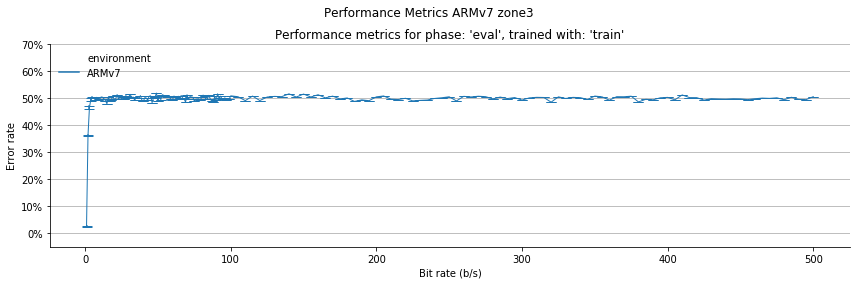

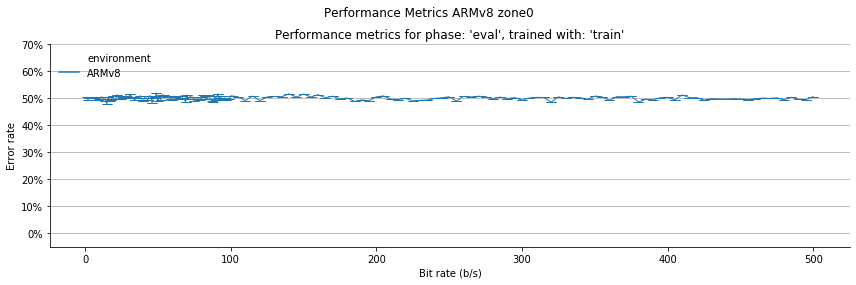

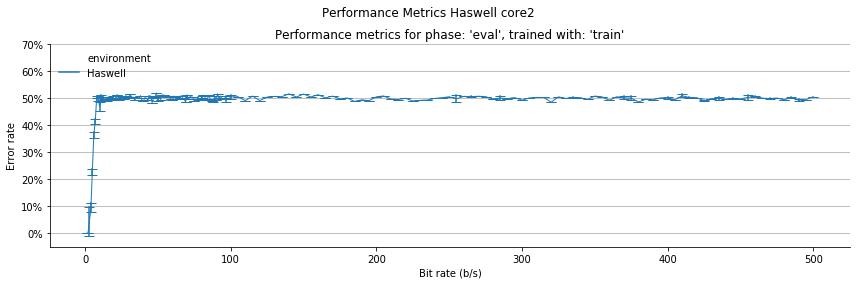

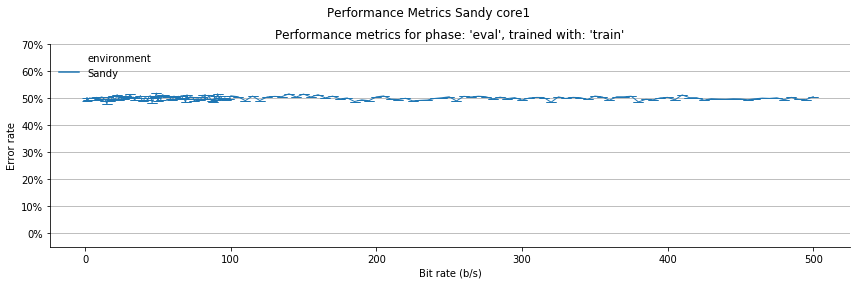

In [8]:
for env in phase_zone_mappings:
    matcher_param = phase_zone_mappings[env]['matcher']
    for zone in matcher_param[3]:
        analysis_args[env]['matcher'] = [(exot.util.wrangle.Matcher(matcher_param[0],
                                                                  matcher_param[1],
                                                                  matcher_param[2],
                                                                  [zone]), None)]
        
        del experiment.performance_metrics
        experiment.calculate_performance_metrics(
            phase_mapping=dict([tuple(phase_zone_mappings[env][to_evaluate])]),
            envs=[env],
            reps=[],
            use_levensthein=False,
            **analysis_args[env],
        )
        # Aggregat performance metrics (mean of repetitions)
        experiment.aggregate_performance_metrics()
        #experiment.write()
        
        # Export data
        eval_phase = phase_zone_mappings[env][to_evaluate][-1]
        BERs = wrangle.filter_data(
            experiment.aggregate_performance_metrics(), environment=env, phase=eval_phase
        )
        
        name_split = NB_EXPERIMENT.split("_")
        if len(name_split) == 2:
            PREFIX = ("interference" if "interference" in NB_EXPERIMENT else "baseline")    
        else:
            if len(name_split) == 3:
                PREFIX = name_split[-1]
            else:
                PREFIX = "all_cores"
        pd.DataFrame({"bit_rate": BERs["bit_rate"], "bit_error": BERs["bit_error"]}).to_csv(
            experiment.path.joinpath("performance_{}_{}_{}{}.dat".format(PREFIX,env,matcher_param[2][0],zone)),
            sep=",",
            encoding="utf-8",
            index=False,
        )
            
        # Plot Performance metrics
        with PerformanceExperimentPlotter(experiment) as plotter:
            plotter.plot_performance_metrics(**{
                "title":"Performance Metrics {} {}{}".format(env,matcher_param[2][0],zone)
            })